# COMP-7950 - Advanced Machine Learning - Project

## Project specification

The project is worth 50% of the final mark associated with the course. The project consists of two parts, which will be equally weighted.

- **Part 1 of the project**

Implement a standard echo state network (ESN) model operating with the feedback of the output. Implement training (i.e. optimization) of the read-out weights by means of the regularized least-square method (i.e. ridge regression) discussed in class. With your implementation, perform simulations on the **flip-flop task** described in the following two references:
1. Ceni et al. Interpreting Recurrent Neural Networks Behaviour via Excitable Network Attractors. Cognitive Computation, 2019
2. Section 3.3 of Sussillo and Barak. Opening the Black Box: Low-Dimensional Dynamics in High-Dimensional Recurrent Neural Networks. Neural Computation, 2013

Perform simulations with 2, 3, and 4 input/output bits for the flip-flop tasks and comments on the results by varying hyperparameters and other settings.

- **Part 2 of the project**

Implement the *online* training algorithm known as FORCE learning. The algorithm was originally introduced in "Sussillo and Abbott, *Generating Coherent Patterns of Activity from Chaotic Neural Networks*, Neuron 2009". The supplementary material of that paper provides access to a matlab implementation of the algorithm, which you might use as a starting point for your own implementation. You should optimize the read-out weights only (as for Part 1 of the project), however implementations of FORCE learning that optimize additional weights (e.g. the recurrent layer and/or the output feedback connections) are permitted. Perform simulations with the resulting online ESN model on the same flip-flop tasks considered in Part 1 (i.e. with 2, 3, and 4 input/output bits) and draw some conclusions on the main differences between the two approaches.

## Your project starts from here!

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# make sure plots are displayed correctly on notebooks
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

### Utility functions and classes

#### Flipflop Class & Data Generation Function

Class implementation of flipflops for simulating input signals and flipflop states.

Data Generation Function for generating input and output signals of given flipflop instance

In [ ]:
class Flipflop():
    def __init__(self, n_bits, random_seed=42):
        """
        Args:
            n_bits: number of bits in the flipflop
            random_seed: random integer seed for setting the initial state
        """
        self.n_bits = n_bits
        self.random_gen_ = np.random.RandomState(random_seed)

    def reset_state(self):
        """
        Initialize the flip flop state uniformly 
        
        Returns:
            The initial state
        """
        return self.random_gen_.choice([+1,-1], size=self.n_bits)

    def next_state(self, prev_state, input_):
        """
        Recieve input and previous state to produce the next state
        Args:
            prev_state: previous state of bits in the flipflop,
                        e.g. n_bits==2 -> any of [[+1,+1], [-1,-1], 
                                                  [+1,-1], [-1,+1]]
            input_: input to the filp flops e.g. n_bits==2,
                   any of [[0, 0], [+1, 0], [-1, 0],
                           [0, +1], [0, -1]]
        Returns:
            The next state based on input and previous state
        """
        return np.array([-e if e==-p else e for e, p in zip(prev_state, input_)])

In [ ]:
def generate_data(flipflop, n, p_zero, random_seed=42):
    """
    Generate data from flipflop
    Args:
        flipflop: flipflop object
        n: size of the data
        p_zero: probability of input being (0, 0)
    Returns:
        Generated input and output data of size n
    """
    random_gen_ = np.random.RandomState(random_seed)

    # Possible choices for input signals (initialized with [0,..0])
    in_choices = [[0]*flipflop.n_bits]
    for i in range(flipflop.n_bits):
        tmp = [0]*flipflop.n_bits

        tmp[i] = +1
        in_choices.append(tmp.copy())

        tmp[i] = -1
        in_choices.append(tmp.copy())
        
    # Initialize the probability of each input signals
    in_prob = np.concatenate(([p_zero], [(1-p_zero)/(len(in_choices)-1)]
                                        *(len(in_choices)-1)))

    input_data = np.zeros((n, flipflop.n_bits))
    output_data = np.zeros((n, flipflop.n_bits))

    # Assigning the initial flipflop state to the first output signal
    output_data[0] = flipflop.reset_state()

    for t in range(1, n):
        rnd_indx = random_gen_.choice(len(in_choices), 1, p=in_prob)[0]
        input_data[t] = in_choices[rnd_indx]
        output_data[t] = flipflop.next_state(output_data[t-1, :], 
                                             input_data[t, :])
        
    return input_data, output_data

#### Metric & Cross Validation Functions

In [ ]:
def metrics(t, y):
    """
    Metrics for assessing prediction performance
    Args:
        t: target signal
        y: prediction signal from the network
    Returns:
        MSE and NRMSE
    """
    mse = np.mean((t - y)**2)
    nrmse = np.sqrt(mse)/np.var(t)

    return mse, nrmse

Since our data is sequential, I take the forward chaining method for k-fold cross-validation. In this method, a continuous chain of size $m, (m\leq k)$ will be selected. The first $m$-$1$ folds will be used as the training data, while the last fold is the validation set.

Since our chain of folds is continuous, the number of validation runs is not $k$ anymore, but it is $k$-$m$+1.

In [ ]:
def cross_validation(k, chain_size, data_in, data_out, net, info="", verbose=False):
    """
    Performing a k-fold cross validation using forward chaining method
    Args:
        k: number of folds
        chain_size: size of chains in forward chaining (chain_size <= k-1)
        data_in: input signal data
        data_out: output signal data
        net: network object
        info: for printing
        verbose: for printing loading
    Returns:
        return mean and var MSE and NRMSE of test folds on esn
    """
    folds_in = np.split(data_in, k)
    folds_out = np.split(data_out, k)

    MSE, NRMSE = [], []
    t = tqdm(range(k-chain_size), leave=True, disable=(not verbose))

    for i in t:
        train_in = np.concatenate(folds_in[i:i+chain_size])
        test_in = folds_in[i+chain_size]
        train_out = np.concatenate(folds_out[i:i+chain_size])
        test_out = folds_out[i+chain_size]

        net.reset()
        net.learn(train_in, train_out)
        test_pr = net.predict(test_in)

        # Discard first 50 steps
        mse, nrmse = metrics(test_pr[50:], test_out[50:])
        MSE.append(mse)
        NRMSE.append(nrmse)

        if i == k-chain_size-1:
            t.set_description(u"{} MSE:{:.2f}\u00B1{:.2f}".format(info,
                                                                  np.mean(MSE),
                                                                  np.var(MSE)))
        else:
            t.set_description("{} MSE:{:.2f}".format(info, mse))

    return (np.hstack([np.mean(MSE),np.var(MSE)]),
            np.hstack([np.mean(NRMSE),np.var(NRMSE)]))

#### Plot functions

In [ ]:
def plot_signals(n, target_out, model_out=None, inputs=None, n_t=500):
    """
    Plot the flipflops signals
    Args:
        n: size of the data
        target_out: target output signals
        model_out: output signals from the network
        inputs: input signals to the flipflops
        n_t: number of timesteps
    """
    fig, axs = plt.subplots(n)
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.rcParams['figure.dpi'] = 100

    for i in range(n):
        axs[i].plot(np.arange(n_t), target_out[:n_t,i], label='target')
        if model_out is not None: 
            axs[i].plot(np.arange(n_t), model_out[:n_t,i], label='model')
        if inputs is not None:
            axs[i].plot(np.arange(n_t), inputs[:n_t,i], label='input', alpha=0.9)
    
    axs[0].legend(loc="upper right")
    plt.show()

In [ ]:
def plot_compare_esn(n, param, _range, feedback_noise=1e-3):
    """
    Compare ESNs for different flipflop sizes with range of params
    Args:
        n: test on flipflop of size [2, ..., n]
        param: name of the param
        _range: range of param 
        feedback_noise: to control the feedback noise for comparing with force
    """
    t = tqdm(range(n-1), desc=param)

    for i in t:
        ff = Flipflop(i+2)
        train_in, train_out = generate_data(ff, 10000, p_zero=0.9, random_seed=42)
        mse = np.zeros((_range.shape[0], 2))

        for j, val in enumerate(_range):
            esn = ESN(i+2, **{param : val, 'feedback_noise': feedback_noise})
            mse[j], _ = cross_validation(10, 6, train_in, train_out, esn)
            t.set_description(u"{}:{}, MSE:{:.3f}\u00B1{:.3f} "
                              .format(param, val, mse[j][0], mse[j][1]))

        t.set_description("{} Done ".format(param))

        plt.plot(_range, mse[:,0], label='N={}'.format(i+2))
    
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.rcParams['figure.dpi'] = 100
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
def plot_compare_force(n, param, _range):
    """
    Compare FORCE for different flipflop sizes with range of params
    Args:
        n: test on flipflop of size [2, ..., n]
        param: name of the param
        _range: range of param 
    """
    t = tqdm(range(n-1), desc=param)

    for i in t:
        ff = Flipflop(i+2)
        train_in, train_out = generate_data(ff, 10000, p_zero=0.9, random_seed=42)
        mse = np.zeros((_range.shape[0], 2))

        for j, val in enumerate(_range):
            esn = FORCE(i+2, **{param : val})
            mse[j], _ = cross_validation(10, 6, train_in, train_out, esn)
            t.set_description(u"{}:{}, MSE:{:.3f}\u00B1{:.3f} "
                              .format(param, val, mse[j][0], mse[j][1]))

        t.set_description("{} Done ".format(param))

        plt.plot(_range, mse[:,0], label='N={}'.format(i+2))
    
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.rcParams['figure.dpi'] = 100
    plt.legend(loc="upper right")
    plt.show()


### Part 1 of the project...

#### Echo State Network Implementation

**_init_weights**

Initialization of the weight matrices in Echo State Network with $N$ reservoir units, $K$ inputs and $L$ outputs is as follows:

> $W_{in}$ which is the input weight matrix and its size is $(N, K)$ is drawn from a uniform distribution of range $[-1, 1]$

> $W_{fb}$ which is the output feedback weight matrix and its size is $(N, L)$ is drawn from a uniform distribution of range $[-1, 1]$

> $W_{res}$ which is the reservoir weight matrix and its size is $(N, N)$ is initialized based on ***Sparsity*** and ***Spectral radius*** values.

**Sparsity** is the probability of reservoir nodes not being connected to each other. This is enforced by changing a portion of the reservoir weight value to zero.

**Spectral radius** is the maximum eigenvalue of the reservoir weight matrix. This is enforced by rescaling reservoir weight.


**_get_resv**

The reservoir states at timestep $x(t$+$1)$ is calculated from current input signal $u(t$+$1)$ and previous reservoir states $x(t)$ and output signal $y(t)$:

$$x(t\text{+}1) = tanh(W_{res}x(t) + W_{in}u(t+1) + W_{fb}y(t)) + \nu(t)$$

The reason behind adding a white noise $\nu(t)$ at each timestep is that stabilizing solutions by shrinking the output weight (regularization).

**_harvest**

After harvesting all reservoir states, we will create extended system states $z(t)$ by concatenating input signals $u(t)$ with reservoir states $x(t)$. Then I stacked these $z(t)$ on top of one another and created the state collection matrix $S$ with size $(n_{max}, N$+$K)$. Also, by stacking the desired outputs $d(t)$, I created the teacher output collection matrix $D$ with size $(n_{max}, L)$.

**_ridge_reg**

To calculate the desired output weights $W_{out}$ (read-out weights) we will follow ridge regression method.

$$W_{out} = (R+\alpha^2I)^{-1}P$$

where $R$ is the correlation matrix of the extended reservoir states $R=\frac{1}{n_{max}}S'S$, and $P$ is the cross-correlation matrix of the extended reservoir states vs. the desired outputs $P=\frac{1}{n_{max}}S'D$.

In [ ]:
class ESN():

    def __init__(self, n_in, n_out=None, n_resv=350, ridge_alpha=1e-8, 
                 state_noise=1e-3, feedback_noise=1e-3, spec_rad=0.02, 
                 sparsity=0.05,random_seed=42, verbose=False):
        """
        Args:
            n_in: input size of the network
            n_out: output size of the network (same as n_in if None)
            n_resv: reservoir size of the network
            ridge_alpha: A nonnegative number for the smoothing effect in,
                         the ridge regression
            state_noise: white noise added to the network for regularization
            feedback_noise: white noise added to the network feedback for 
                            robustness against unstable feedback
            spec_rad: maximum spectral radius for the reservoir weight matrix
            sparsity: sparsity of the reservoir weight matrix (0, 1]
            random_seed: random integer seed for setting the initial state
            verbose: for debug purposes
        """
        self.n_in = n_in
        self.n_out = n_out if n_out else n_in
        self.n_resv = int(n_resv)
        self.ridge_alpha = ridge_alpha
        self.state_noise = state_noise
        self.feedback_noise = feedback_noise
        self.spec_rad = spec_rad
        self.sparsity = sparsity
        self.random_seed = random_seed
        self.random_gen_ = np.random.RandomState(random_seed)
        self.verbose = verbose

        self._init_weights()

    def _init_weights(self):
        """
        Initialize the input, reservoir, and feedback weight matrices
        """
        self.W_in = self.random_gen_.uniform(-1, 1, (self.n_resv, self.n_in))

        self.W_fb = self.random_gen_.uniform(-1, 1, (self.n_resv, self.n_out))

        self.W_res = self.random_gen_.uniform(-0.5, 0.5, (self.n_resv, self.n_resv))

        # randomly remove some connections
        rand_idxs = self.random_gen_.rand(*self.W_res.shape) < (1 - self.sparsity)
        self.W_res[rand_idxs] = 0

        # rescale to reach the maximum spectral radius
        curr_radius = np.max(np.abs(np.linalg.eigvals(self.W_res)))
        self.W_res = self.W_res * (self.spec_rad / curr_radius)

    def _get_resv(self, x_t, u_t_, y_t):
        """
        Get the next reservoir state by the state update equation
        Args:
            x_t: reservoir state at timestep t-1
            u_t_: input signal at timestep t
            y_t: output signal at timestep t-1
        Returns:
            Reservoir state at timestep t
        """ 
        return (np.tanh(self.W_res @ x_t + self.W_in @ u_t_ + self.W_fb @ y_t) + 
                self.random_gen_.normal(size=(self.n_resv)) * self.state_noise)

    def _harvest(self, U, D):
        """
        Harvest reservoir states with given input and previous states
        Args:
            U: matrix of inputs to the network (n_max, n_in) 
            D: matrix of outputs of the network (n_max, n_out)
        Returns:
            Extended system states
        """
        n_max = U.shape[0] # dataset size
        X = np.zeros((n_max, self.n_resv)) # matrix of reservoir states
        # Added noise to the output
        D += self.random_gen_.normal(size=D.shape) * self.feedback_noise

        tq = tqdm(range(1, n_max), disable=(not self.verbose), desc='Harvesting')
        for t in tq:
            X[t] = self._get_resv(X[t-1], U[t], D[t-1])
        
        S = np.hstack((X, U)) # extended system states (n_max, n_resv + n_in)
            
        return S

    def _ridge_reg(self, S, D):
        """
        Solve for the W_out with ridge regression method
        Args:
            S: matrix of extended system states (n_max, n_resv + n_in) 
            D: matrix of outputs of the network (n_max, n_out)
        """
        n_max = S.shape[0] # dataset size
        R = (1/n_max) * (S.T @ S) # (n_resv + n_in, n_resv + n_in)
        I = np.eye(self.n_resv + self.n_in) # (n_resv + n_in, n_resv + n_in)
        P = (1/n_max) * (S.T @ D) # (n_resv + n_in, n_out)

        self.W_out = np.linalg.inv(R + self.ridge_alpha**2 * I) @ P # (n_resv + n_in, n_out)
        # self.W_out = (np.linalg.pinv(S) @ D)

    def reset(self):
        """
        Reset the weights to the initial values
        """
        self.random_gen_ = np.random.RandomState(self.random_seed)
        self._init_weights()

    def learn(self, inputs, outputs):
        """
        Train the out weight with the given dataset of inputs and outputs
        Args:
            inputs: matrix of inputs to the network (n_max, n_in) 
            outputs: matrix of outputs of the network (n_max, n_in)
        """
        S = self._harvest(inputs, outputs)
        self._ridge_reg(S, outputs)

    def predict(self, inputs):
        """
        Predict the output using the network weights
        Args:
            inputs: matrix of inputs to the network (n_max, n_in)
        Returns:
            Matrix of outputs from the network 
        """
        n_max = inputs.shape[0]
        prev_x = np.zeros(self.n_resv)
        prev_u = inputs[0]
        prev_y = np.hstack((prev_x,)) @ self.W_out
        outputs = np.zeros((n_max, self.n_out))

        tq = tqdm(range(1, n_max), disable=(not self.verbose), desc='Predicting')
        for t in tq:
            prev_x = self._get_resv(prev_x, prev_u, prev_y)
            prev_y = np.hstack((prev_x, prev_u)) @ self.W_out
            outputs[t-1] = prev_y.copy()
            prev_u = inputs[t]

        prev_x = self._get_resv(prev_x, prev_u, prev_y)
        outputs[-1] = np.hstack((prev_x, prev_u)) @ self.W_out

        return outputs

#### Comparing Hyperparameters

Here I have tested the ESN method on 3 flipflop tasks (with sizes 2, 3, and 4) with varying reservoir units. In this plot, the x-axis indicates reservoir units. The y-axis is the average MSE across 5 folds with a training size of 5000 and validation size of 1000.


As you can see for N=2 and N=3, there is no performance gain after 350 reservoir units. While in N=4, larger sizes of reservoir units improve the performance.

In [ ]:
plot_compare_esn(4, 'n_resv', np.linspace(150, 700, 11), feedback_noise=0)

NameError: ignored

I have tested the ESN method on 3 flipflop tasks (with sizes 2, 3, and 4) on a range of added noise to each reservoir state. In this plot, the x-axis (log scale) indicates the variance of the noise. The y-axis is the average MSE across 5 folds with a training size of 5000 and validation size of 1000.


As you can see for N=2 and N=3, there is no performance by adding noise to the reservoir state. While in N=4 range $[5e$-$4, 15e$-$4$] shows better results.

In my opinion, state noise improves the N=4 performance because it acts as a regularizer and tries to disentangle the effect of unmatching input and output signals.

In [ ]:
plot_compare_esn(4, 'state_noise', np.logspace(-4, -2.5, 11), feedback_noise=0)

state_noise:   0%|          | 0/3 [00:01<?, ?it/s]


ValueError: ignored

I have tested the ESN method on 3 flipflop tasks (with sizes 2, 3, and 4) on a range of different spectral radius. In this plot, the x-axis (log scale) indicates the maximum spectral radius. The y-axis is the average MSE across 5 folds with a training size of 5000 and validation size of 1000.

As we add more flipflops, the negative effect of increasing spectral radius becomes more evident.

This negative effect is that a larger spectral radius implies slower decay of impulse response. The flipflop task requires the output to change as soon as the input changes when a larger spectral radius causes slower impulse response decay. Plus, a larger spectral radius implies longer-range interactions between the reservoir units when here inputs and outputs are controlled separately.

In [ ]:
plot_compare_esn(4, 'spec_rad', np.logspace(-2, 0, 11), feedback_noise=0)

Lastly, I have tested the ESN method on 3 flipflop tasks (with sizes 2, 3, and 4) with varying the sparsity of the reservoir network. In this plot, the x-axis (log scale) indicates the probability of sparsity. The y-axis is the average MSE across 5 folds with a training size of 5000 and validation size of 1000.

Here fully connected reservoirs work as well as sparsely connected ones for N=2. I believe that this is also the case for N=3 and N=4. The reason behind the fluctuations for N>2 cases is the uneven association of reservoir units with each flipflop.

In [ ]:
plot_compare_esn(4, 'sparsity', np.logspace(-1.5,-0.1, 11), feedback_noise=0)

#### Testing on 2, 3, and 4 Flip-Flop case

Here I have shown the ESN performance on test data:

> For N=2, you can see that the model's output is far off from the target signal in the first few steps. But after step 200, the model starts to align perfectly with the target. By this, one can also see the Echo State Property.

In [ ]:
N = 2
ff = Flipflop(N)
train_in, train_out = generate_data(ff, 6000, p_zero=0.9, random_seed=42)
test_in, test_out = generate_data(ff, 500, p_zero=0.9, random_seed=77)

esn = ESN(N, feedback_noise=0, verbose=True)
esn.learn(train_in, train_out)
test_pr = esn.predict(test_in)

mse, nrmse = metrics(test_pr, test_out)
print("MSE:{} NRMSE:{}".format(mse, nrmse))
plot_signals(N, test_out, test_pr, test_in, n_t=500)

Harvesting: 100%|██████████| 5999/5999 [00:00<00:00, 8305.83it/s]


ValueError: ignored

> For N=3, you can see there are some anomalies in steps 250, 290, and 340. I believe the reason behind these anomalies is those reservoir units associated with each of the flipflops are not completely disentangled from one another and are having effects on each other's outputs. For example, in step 250, the first flipflop's input is -1, causing the third flipflop to deviate from the correct output.

In [ ]:
N = 3
ff = Flipflop(N)
train_in, train_out = generate_data(ff, 6000, p_zero=0.9, random_seed=42)
test_in, test_out = generate_data(ff, 1000, p_zero=0.9, random_seed=77)

esn = ESN(N, n_resv=500, sparsity=0.8, feedback_noise=0, verbose=True)
esn.learn(train_in, train_out)
test_pr = esn.predict(test_in)

mse, nrmse = metrics(test_pr, test_out)
print("MSE:{} NRMSE:{}".format(mse, nrmse))
plot_signals(N, test_out, test_pr, test_in, n_t=500)

> For N=4, the anomalies are getting out of control. The fact that some outputs are now out of the $[-1, 1]$ range is diminishing the performance even further.

In [ ]:
N = 4
ff = Flipflop(N)
train_in, train_out = generate_data(ff, 6000, p_zero=0.9, random_seed=42)
test_in, test_out = generate_data(ff, 1000, p_zero=0.9, random_seed=77)

esn = ESN(N, n_resv=700, feedback_noise=0, verbose=True)
esn.learn(train_in, train_out)
test_pr = esn.predict(test_in)

mse, nrmse = metrics(test_pr, test_out)
print("MSE:{} NRMSE:{}".format(mse, nrmse))
plot_signals(N, test_out, test_pr, test_in, n_t=500)

### Part 2 of the project...

#### Force Network Implementation

**_init_weights**

Initialization of the weight matrices in Echo State Network with $N$ reservoir units, $K$ inputs and $L$ outputs is as follows:

> $P$ which is estimate of the inverse of the network rates correlation matrix plus a regularization term and its size is $(N, N)$ is the identity matrix scaled by $\alpha$

> $J^{GI}$ which is the input weight matrix and its size is $(N, K)$ is drawn from a Gaussian distribution with zero mean and unit variance.

> $J^{Gz}$ which is the output feedback weight matrix and its size is $(N, L)$ is drawn from a uniform distribution of range $[-1, 1]$

> $J^{GG}$ which is the reservoir weight matrix and its size is $(N, N)$ is drawn from a Gaussian distribution with zero mean and variance $\frac{1}{p_{GG}N}$.

Similar to **Sparsity** probability in ESN, here reservoir elements are set and held to 0 with probability $1$-$p_{GG}$

> $W_{out}$ which is the read-out weight matrix and its size is $(N, L)$ is drawn from a Gaussian distribution with zero mean and variance $\frac{1}{p_{z}N}$.

Readout weight elements are also set and held to 0 with probability $1$-$p_{z}$


**_get_resv**

Given $r(t) = tanh(x(t))$, $z(t) = W_{out}^Tr(t)$, input signal $u(t)$, and time constant $\tau$, resviour state ODE is as follows:

$$\tau \frac{dx(t)}{dt} = -x(t)+g_{GG}J^{GG}r(t) + g_{Gz}J^{Gz}z(t) + J^{GI}u(t)$$

$$x(t+1) = x(t)+\frac{dt}{\tau}dx(t)$$

In the code I have taken the ratio $\frac{dt}{\tau}$ as $\eta$ and lets assume $R \equiv g_{GG}J^{GG}r(t) + g_{Gz}J^{Gz}z(t) + J^{GI}u(t)$, which what $\texttt{_get_resv}$ function returns:

$$x(t+1) = x(t)+\eta(-x(t)+R)$$

$$x(t+1) = (1-\eta)x(t)+\eta R$$

**_update_weights**

Every $\Delta t$ step I will update $P$ and $W_{out}$ matrices given that $r(t)=tanh(x(t))$, desired output signal $f(t)$, and $e_{-}(t)=W_{out}^T(t-\Delta t)r(t) - f(t)$:

$$P(t) = P(t-\Delta t) - \frac{P(t-\Delta t)r(t)r^T(t)P(t-\Delta t)}{1+r^T(t)P(t-\Delta t)r(t)}$$

$$W_{out}(t) = W_{out}(t-\Delta t)-e_{-}(t)P(t)r(t)$$



In [ ]:
class FORCE():

    def __init__(self, n_in, n_out=None, n_resv=500, alpha=1, train_freq=5,
                 g_gg=1.0, g_gz=0.6, p_gg=0.8, p_z=1.0, eta=0.75,
                 random_seed=42, verbose=False):
        """
        Args:
            n_in: input size of the network
            n_out: output size of the network 
            n_resv: reservoir size of the network
            alpha: Inverse of the learning rate
            train_freq: Frquancy of the P and read-out weight update 
            g_gg: scaling factor of the reservoir weight matrix of the network
            g_gz: scaling factor of the feedback loop
            p_gg: sparsity of the reservoir weight matrix (0, 1]
            p_z: sparsity of the readout unit (0, 1]
            eta: network integration time step to time constant of the units 
                 dynamics ratio (0, 1]
            random_seed: random integer seed for setting the initial state
            verbose: for debug purposes
        """
        self.n_in = n_in
        self.n_out = n_out if n_out else n_in
        self.n_resv = int(n_resv)
        self.alpha = alpha
        self.train_freq = train_freq
        self.g_gg = g_gg
        self.g_gz = g_gz
        self.p_gg = p_gg
        self.p_z = p_z
        self.random_seed = random_seed
        self.random_gen_ = np.random.RandomState(random_seed)
        self.verbose = verbose
        self.eta = eta

        self._init_weights()

    def _init_weights(self):
        """
        Initialize the input, reservoir, feedback, read-out weight and P matrices
        """
        # Inverse of the network rates correlation matrix with regularization
        self.P = np.identity(self.n_resv) * (1./self.alpha)

        # Same as W_in
        self.J_GI = self.random_gen_.normal(0, 1, (self.n_resv, self.n_in))

        # Same as W_fb
        self.J_Gz = self.random_gen_.uniform(-1, 1, (self.n_resv, self.n_out))

        # Same as W_res
        self.J_GG = self.random_gen_.normal(0, 1/np.sqrt(self.n_resv * self.p_gg), 
                                            (self.n_resv, self.n_resv))

        # Randomly remove some connections
        rand_idxs = self.random_gen_.rand(*self.J_GG.shape) < (1 - self.p_gg)
        self.J_GG[rand_idxs] = 0

        self.W_out = self.random_gen_.normal(0, 1/((self.n_resv) * self.p_z), 
                                             (self.n_resv, self.n_out))

        # Randomly set weigths to zero
        rand_idxs = self.random_gen_.rand(*self.W_out.shape) < (1 - self.p_z)
        self.W_out[rand_idxs] = 0

    def _get_resv(self, x_t, u_t):
        """
        Get the next reservoir state by the state update equation
        Args:
            x_t: reservoir state at timestep t-1
            u_t: input signal at timestep t-1
        Returns:
            Reservoir state at timestep t-1
        """
        z_t = self.W_out.T @ np.tanh(x_t)

        return (self.g_gg * (self.J_GG @ np.tanh(x_t)) +
                self.g_gz * (self.J_Gz @ z_t) +
                self.J_GI @ u_t)

    def _update_weights(self, x_t, u_t, y_t):
        """
        Update read-out weights and P
        Args:
            x_t: reservoir state at timestep t-1
            u_t: input signal at timestep t-1
            y_t: output signal at timestep t-1
        Returns:
            Absolute value of weight delta
        """
        r_t = np.tanh(x_t).reshape(-1, 1)
        
        ps = self.P @ r_t
        sp = r_t.T @ self.P
        self.P -= (ps @ sp) / (1 + sp @ r_t)
        
        e_ = (self.W_out.T @ r_t) - y_t.reshape(-1, 1) 
        dw = self.P @ r_t @ e_.T

        self.W_out -= dw

        return np.sum(np.absolute(dw))

    def reset(self):
        """
        Reset the weights to the initial values
        """
        self.random_gen_ = np.random.RandomState(self.random_seed)
        self._init_weights()

    def learn(self, inputs, outputs):
        """
        Train the out weight with the given dataset of inputs and outputs
        Args:
            inputs: matrix of inputs to the network (n_max, n_in) 
            outputs: matrix of outputs of the network (n_max, n_in)
        """
        n_max = inputs.shape[0]
        self.x_t = 0.5 * self.random_gen_.randn(self.n_resv)
        self.abs_w = np.zeros(n_max)

        tq = tqdm(range(1, n_max), disable=(not self.verbose), desc='Learning')
        for t in tq:
            self.x_t = ((1-self.eta) * self.x_t + 
                        self.eta * self._get_resv(self.x_t, inputs[t-1]))
            if t % self.train_freq == 0:
                self.abs_w[t] = self._update_weights(self.x_t, 
                                                     inputs[t-1], 
                                                     outputs[t-1])

    def predict(self, inputs):
        """
        Predict the output using the network weights
        Args:
            inputs: matrix of inputs to the network (n_max, n_in)
        Returns:
            Matrix of outputs from the network 
        """
        n_max = inputs.shape[0]
        prev_u = inputs[0]
        outputs = np.zeros((n_max, self.n_out))

        tq = tqdm(range(1, n_max), disable=(not self.verbose), desc='Predicting')
        for t in tq:
            self.x_t = ((1-self.eta) * self.x_t + 
                        self.eta * self._get_resv(self.x_t, prev_u))
            prev_y = self.W_out.T @ np.tanh(self.x_t)
            outputs[t-1] = prev_y
            prev_u = inputs[t]

        self.x_t = ((1-self.eta) * self.x_t + 
                    self.eta * self._get_resv(self.x_t, prev_u))
        outputs[-1] = self.W_out.T @ np.tanh(self.x_t)

        return outputs

#### Comparing Hyperparameters

Here I have tested the FORCE method on 3 flipflop tasks (with sizes 2, 3, and 4) with varying reservoir units. In this plot, the x-axis indicates reservoir units. The y-axis is the average MSE across 5 folds with a training size of 5000 and validation size of 1000.


As you can see for N=2 and N=3, there is no performance gain after 250 and 450 reservoir units, respectively. While in N=4, larger sizes of reservoir units improve the performance.

n_resv Done : 100%|██████████| 3/3 [09:25<00:00, 188.53s/it]


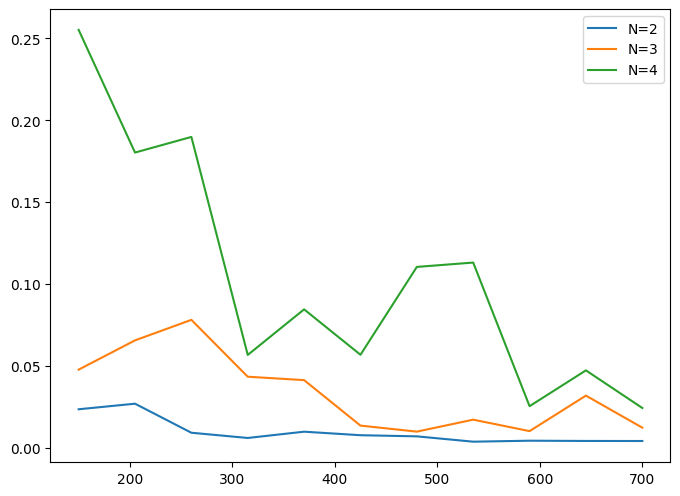

In [ ]:
plot_compare_force(4, 'n_resv', np.linspace(150, 700, 11))

I have tested the FORCE method on 3 flipflop tasks (with sizes 2, 3, and 4) on a range of inverse learning rate $\alpha$. In this plot, the x-axis indicates $\alpha$. The y-axis is the average MSE across 5 folds with a training size of 5000 and validation size of 1000.

As we increase the value of $\alpha$, learning is getting slower and doesn't show good performance under a fixed amount of training steps.

alpha Done : 100%|██████████| 3/3 [12:23<00:00, 247.71s/it]


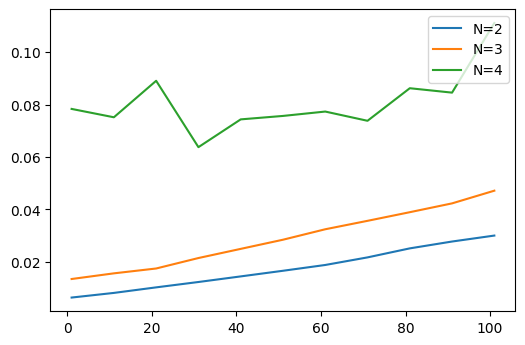

In [ ]:
plot_compare_force(4, 'alpha', np.linspace(1, 101, 11))

I have tested the FORCE method on 3 flipflop tasks (with sizes 2, 3, and 4) on a range of reservoir weight scaling factor. In this plot, the x-axis indicates $g_{GG}$. The y-axis is the average MSE across 5 folds with a training size of 5000 and validation size of 1000.

For $g_{GG} > 1$ the network will show chaotic behavior. Usually, as shown in the paper, chaotic networks help the learning process. However, this is not the case for our flipflop task. By moving toward a more chaotic network, we are giving more weight to reservoir states. Due to the reservoir network's connectivity, this might cause interference between different flipflops and deteriorate performance.

g_gg Done : 100%|██████████| 3/3 [12:17<00:00, 245.98s/it]


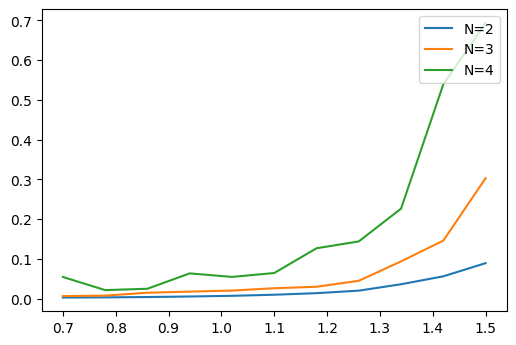

In [ ]:
plot_compare_force(4, 'g_gg', np.linspace(0.7, 1.5, 11))

I have tested the FORCE method on 3 flipflop tasks (with sizes 2, 3, and 4) with varying output weight scaling factor and the sparsity of the reservoir network. In the 2 following plot, the x-axis indicates $g_{Gz}$ and $p_{GG}$, respectively. The y-axis is the average MSE across 5 folds with a training size of 5000 and validation size of 1000.

These two hyperparameter doesn't show any effect on the performance. I believe that this is also the case for N=3 and N=4. The reason behind the fluctuations for N>2 cases is the uneven association of reservoir units with each flipflop.

g_gz Done : 100%|██████████| 3/3 [10:38<00:00, 212.98s/it]


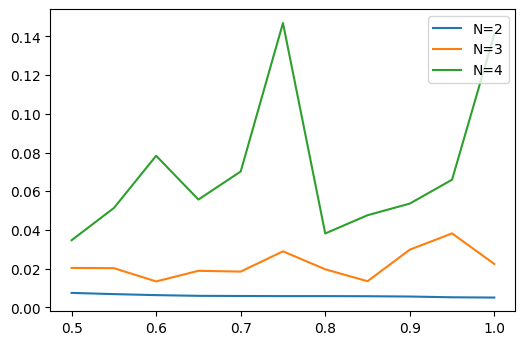

In [ ]:
plot_compare_force(4, 'g_gz', np.linspace(0.5, 1.0, 11))

p_gg Done : 100%|██████████| 3/3 [09:44<00:00, 194.94s/it]


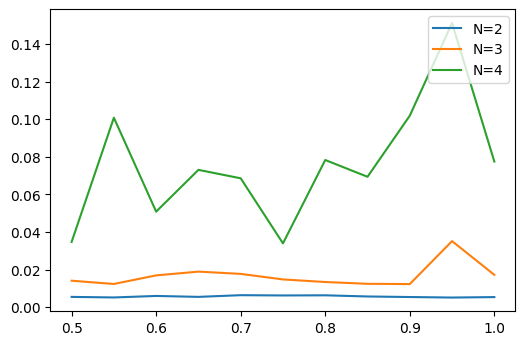

In [ ]:
plot_compare_force(4, 'p_gg', np.linspace(0.5, 1.0, 11))

Lastly, I have tested the FORCE method on 3 flipflop tasks (with sizes 2, 3, and 4) with varying network integration time step to time constant ratio. In this plot, the x-axis indicates $\eta$. The y-axis is the average MSE across 5 folds with a training size of 5000 and validation size of 1000.

I found out that $\eta$ works as a smoothing constant similar to leaky ESN from experiments. Large values of $\eta$ will cause too much fluctuation, making it impossible for FORCE to learn the desired signal. While smaller values of $\eta$ are too slow to show proper response, again undermining the learning process.

tau Done : 100%|██████████| 3/3 [09:52<00:00, 197.46s/it]


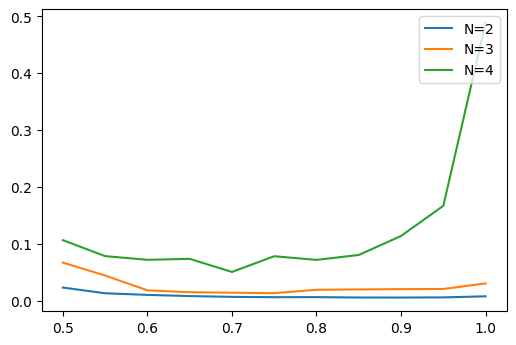

In [ ]:
plot_compare_force(4, 'eta', np.linspace(0.5, 1.0, 11))

#### Testing on 2, 3, and 4 Flip-Flop case

Here I have shown the FORCE performance on test data:

> For N=2, unlike the ESN output, this approach shows small fluctuations around the target signal. This is because we are calculating $W_{out}$ with the estimate of the inverse of the network rates correlation matrix, while this is not the case in ESN. Also, because this method is not dependent on the teacher signal, it can align with the target signal faster (no cold start). 

Predicting: 100%|██████████| 499/499 [00:00<00:00, 3941.35it/s]


MSE:0.008354210454990792 NRMSE:0.09429588777937174


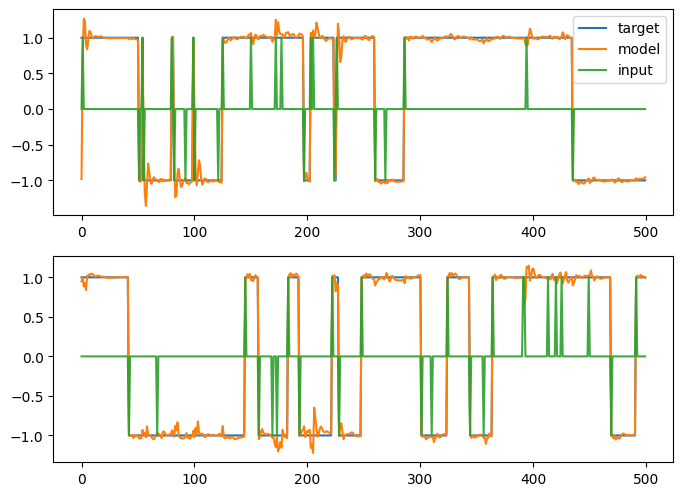

In [ ]:
N = 2
ff = Flipflop(N)
train_in, train_out = generate_data(ff, 10000, p_zero=0.9, random_seed=42)
test_in, test_out = generate_data(ff, 500, p_zero=0.9, random_seed=77)

force = FORCE(N, verbose=True)

force.learn(train_in, train_out)
test_pr = force.predict(test_in)

mse, nrmse = metrics(test_pr, test_out)
print("MSE:{} NRMSE:{}".format(mse, nrmse))
plot_signals(N, test_out, test_pr, test_in, n_t=500)

> For N=3 and N=4, there are no anomalies like ESN's output. The network can now sample fluctuations during training, which prevents the output from deviating far off from the desired signal.

Predicting: 100%|██████████| 499/499 [00:00<00:00, 3474.33it/s]


MSE:0.11736014042716705 NRMSE:0.3373976152542814


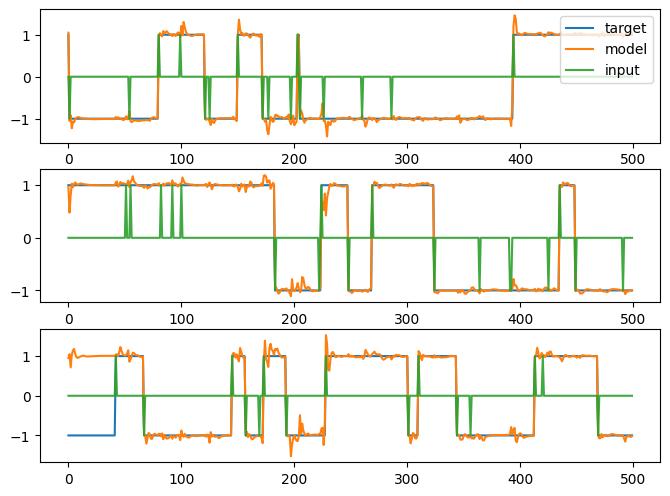

In [ ]:
N = 3
ff = Flipflop(N)
train_in, train_out = generate_data(ff, 10000, p_zero=0.9, random_seed=42)
test_in, test_out = generate_data(ff, 500, p_zero=0.9, random_seed=77)

force = FORCE(N, n_resv=600, verbose=True)

force.learn(train_in, train_out)
test_pr = force.predict(test_in)

mse, nrmse = metrics(test_pr, test_out)
print("MSE:{} NRMSE:{}".format(mse, nrmse))
plot_signals(N, test_out, test_pr, test_in, n_t=500)

Predicting: 100%|██████████| 499/499 [00:00<00:00, 2747.63it/s]


MSE:0.010453780646972548 NRMSE:0.1066781311972139


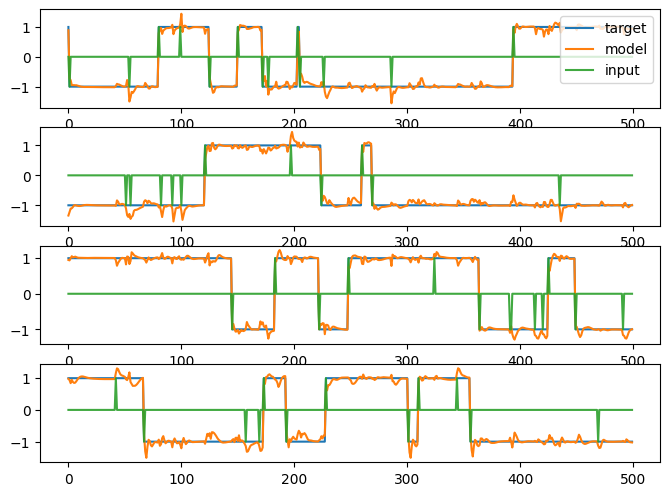

In [ ]:
N = 4
ff = Flipflop(N)
train_in, train_out = generate_data(ff, 10000, p_zero=0.9, random_seed=42)
test_in, test_out = generate_data(ff, 500, p_zero=0.9, random_seed=77)

force = FORCE(N, n_resv=700, g_gz=0.8, alpha=10, verbose=True)

force.learn(train_in, train_out)
test_pr = force.predict(test_in)

mse, nrmse = metrics(test_pr, test_out)
print("MSE:{} NRMSE:{}".format(mse, nrmse))
plot_signals(N, test_out, test_pr, test_in, n_t=500)

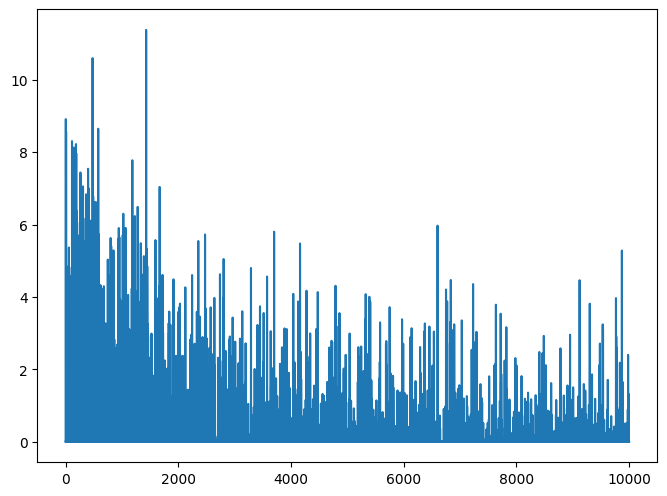

In [ ]:
plt.plot(range(len(force.abs_w)), force.abs_w)

### Extra

Here I have added an extra experiment to show that we can allow the network to sample fluctuations during training by adding some white noise to the teacher signal. This will lead to more stable performance throughout different flipflop sizes.

MSE:0.12783028272913244 NRMSE:0.3731108634332575


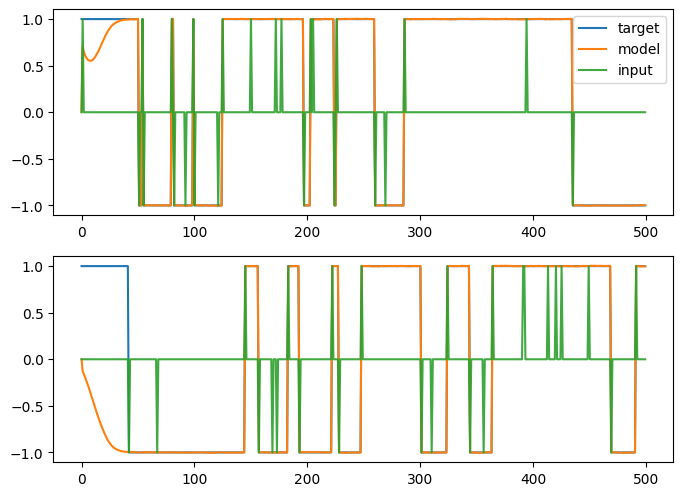

In [ ]:
N = 2
ff = Flipflop(N)
train_in, train_out = generate_data(ff, 6000, p_zero=0.9, random_seed=42)
test_in, test_out = generate_data(ff, 500, p_zero=0.9, random_seed=77)

esn = ESN(N)
esn.learn(train_in, train_out)
test_pr = esn.predict(test_in)

mse, nrmse = metrics(test_pr, test_out)
print("MSE:{} NRMSE:{}".format(mse, nrmse))
plot_signals(N, test_out, test_pr, test_in, n_t=500)

MSE:0.09860567164462204 NRMSE:0.3717833252886002


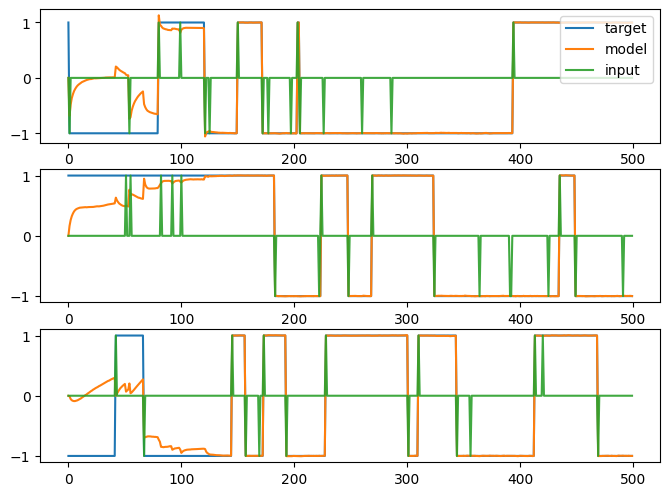

In [ ]:
N = 3
ff = Flipflop(N)
train_in, train_out = generate_data(ff, 6000, p_zero=0.9, random_seed=42)
test_in, test_out = generate_data(ff, 500, p_zero=0.9, random_seed=77)

esn = ESN(N)
esn.learn(train_in, train_out)
test_pr = esn.predict(test_in)

mse, nrmse = metrics(test_pr, test_out)
print("MSE:{} NRMSE:{}".format(mse, nrmse))
plot_signals(N, test_out, test_pr, test_in, n_t=500)

MSE:0.3191349268414395 NRMSE:0.6723152229969785


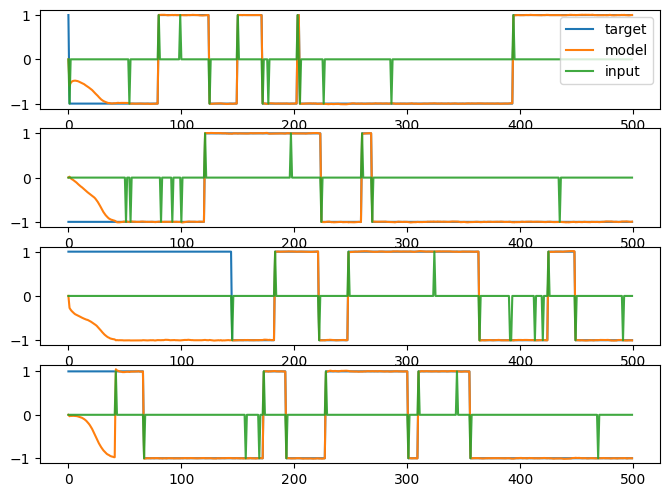

In [ ]:
N = 4
ff = Flipflop(N)
train_in, train_out = generate_data(ff, 6000, p_zero=0.9, random_seed=42)
test_in, test_out = generate_data(ff, 500, p_zero=0.9, random_seed=77)

esn = ESN(N)
esn.learn(train_in, train_out)
test_pr = esn.predict(test_in)

mse, nrmse = metrics(test_pr, test_out)
print("MSE:{} NRMSE:{}".format(mse, nrmse))
plot_signals(N, test_out, test_pr, test_in, n_t=500)